<a href="https://colab.research.google.com/github/Yunho-seo/education_center6/blob/main/20230607.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비지도학습
- 잠재변수(latent variables)
  - generative / discriminative
  - 생성과 판별
  - 생성 Network : AE, VAE, GAN
  - 판별 Network : tree model, FFNN, CNN
- UpSampling
  - Target이 자기자신 (추출된 특징이 다시 원본으로 복원하는 과정에서 사이즈를 확대)
- KL Divergency
  - Cross Entropy cost function
  - 실제, 생성 데이터 2개가 출력, 두 Cross Entropy의 차이를 계산하는 것(분포차를 계산)
- AE(Auto encoder) : RBM에서 FFNN망으로 확대
- VAE(variationalAE) : 추출된 특징에 분산을 추가 (정규분포로부터) -> 다양한 출력을 생성
- GAN(Generative adverserial network)
  - fake image generator / real image
  - discriminator를 이용하여 표현
  - 판별결과로 generator의 가중치를 수정한다.

In [2]:
# CNN망에서 downSampling하였는데, 자기 이미지 사이즈로 복원하기 위해
# UpSampling이 필요하다 (비지도학습) -> Object Detction
import numpy as np
print(np.sum((10, 20)))
np.prod((10, 20))
import tensorflow as tf
input_shape = (2, 2, 1, 3)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
print(x)
y = tf.keras.layers.UpSampling2D(size = (1, 2))(x)  # 업샘플링 (크기를 (1, 2)로 확대하는 작업)
print(y)

30
[[[[ 0  1  2]]

  [[ 3  4  5]]]


 [[[ 6  7  8]]

  [[ 9 10 11]]]]
tf.Tensor(
[[[[ 0  1  2]
   [ 0  1  2]]

  [[ 3  4  5]
   [ 3  4  5]]]


 [[[ 6  7  8]
   [ 6  7  8]]

  [[ 9 10 11]
   [ 9 10 11]]]], shape=(2, 2, 2, 3), dtype=int64)


In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data()  # 훈련 / 테스트 데이터
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255  # 형태 변환 및 정규화(0 ~ 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
autoencoder = Sequential()  # Sequential 모델을 생성하여 오토인코더 변수에 할당 (순차적으로 계층을 쌓아 Autoencoder 모델 구성)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# batch_size = 128
# 128 x 28 x 28 x 1
# 필터 사이즈 3x3
# 학습될 이미지가 입력된다.
autoencoder.add(Conv2D(16, kernel_size = 3, padding = 'same', input_shape = (28, 28, 1),
                       activation = 'relu'))  # 128 x 28 x 28 x 16 채널 
autoencoder.add(MaxPooling2D(pool_size = 2, padding = 'same'))  # 128 x 14 x 14 x 16
autoencoder.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))  # 128 x 14 x 14 x 8
autoencoder.add(MaxPooling2D(pool_size = 2, padding = 'same'))  # 128 x 7 x 7 x 8
autoencoder.add(Conv2D(8, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'))
# Flatten
# 128 x 4 x 4 x 8 -> 데이터 압축 (비지도 학습의 학습 결과)
# Encoder
# 뒷단에 FFNN이 붙어야 함 -> decoder가 대신함 
# Flatten된 데이터를 받아 reshape()하여 진행
autoencoder.add(Conv2D(8, kernel_size = 3, padding = 'same', activation = 'relu'))  # 128 x 4 x 4 x 8
autoencoder.add(UpSampling2D())  # 128 x 8 x 8 x 8 (Upsampling, 사이즈가 배로 늘어남)
autoencoder.add(Conv2D(8, kernel_size = 3, padding = 'same', activation = 'relu'))  # 128 x 8 x 8 x 8
autoencoder.add(UpSampling2D())  # 128 x 16 x 16 x 8
autoencoder.add(Conv2D(16, kernel_size = 3, activation = 'relu'))  # 128 x 14 x 14 x 8
autoencoder.add(UpSampling2D()) # 128 x 28 x 28 x 8
# 원본 이미지로 복원 -> Decoder
autoencoder.add(Conv2D(1, kernel_size = 3, padding = 'same', activation = 'sigmoid'))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           5

Epoch 1/50
469/469 [==============================] - 18s 9ms/step - loss: 0.2129 - val_loss: 0.1338
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1234 - val_loss: 0.1144
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1113 - val_loss: 0.1071
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1057 - val_loss: 0.1027
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1023 - val_loss: 0.0999
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0999 - val_loss: 0.0981
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0980 - val_loss: 0.0959
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0964 - val_loss: 0.0945
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0949 - val_loss: 0.0931
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0935 - val_loss: 0.091

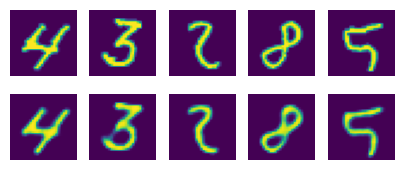

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
# X_train을 입력으로 받아 자기자신을 출력으로 예측하는 방식으로 Autoencoder 학습한다. 검증 데이터는 X_test
autoencoder.fit(X_train, X_train, epochs = 50, batch_size = 128, validation_data = (X_test,
                                                                                    X_test))
# 학습 후, 이미지를 랜덤수로 생성
random_test = np.random.randint(X_test.shape[0], size = 5)  # 무작위로 5개의 이미지 인덱스 선택
ae_imgs = autoencoder.predict(X_test)  # 복원된 데이터 / autoencoder 사용하여 X_test 데이터를 재구성한 결과인 ae_imgs 생성
plt.figure(figsize = (7, 2))
for i, image_idx in enumerate(random_test):
  ax = plt.subplot(2, 7, i + 1)
  plt.imshow(X_test[image_idx].reshape(28, 28))   # 원본 데이터(이미지) X_test
  ax.axis('off')
  ax = plt.subplot(2, 7, 7 + i + 1)
  plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 복원된 데이터 ae_imgs
  ax.axis('off')
plt.show()
# 오토인코더 모델을 학습하고, 학습된 모델을 사용하여 테스트 데이터의 이미지를 복원한 결과를 시각화

In [ ]:
# 비지도학습의 결과를 분류기에 입력하기 위해, 압축표현된 결과값을 얻고 싶은 경우
# 이를 획득하기 위해 network 구조를 변경하는 방안을 생각해보기

In [ ]:
# 데이터 압축

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()  # 의류 관련 이미지 데이터셋 로드
x_train = x_train.astype('float32') / 255  # float 자료형으로 변환하고 0 ~ 255 값을 0 ~ 1로 정규화
x_test = x_test.astype('float32') / 255    # 정규화하는 이유 : 이미지 데이터를 신경망 모델에 주입하기 위해 픽셀 값의 범위를 조정
print(x_train.shape)  # (60000, 28, 28)
print(x_test.shape)   # (10000, 28, 28)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
latent_dim = 64
class Autoencoder(Model):  # Autoencoder 모델은 Model 클래스를 상속받는다.
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim  # 멤버 변수로 설정 
        # 네트워크를 2개로 분할
        self.encoder = tf.keras.Sequential([  # 인코더 : 입력 데이터를 압축 / 순차적으로 진행
            layers.Flatten(),  # 784
            # 784 x 64  # 학습결과 => PCA를 진행한 결과와 같다.
            layers.Dense(latent_dim, activation='relu'),  # 마지막으로 계산된것이 리턴된다.
        ])
        self.decoder = tf.keras.Sequential([  # 디코더 : 압축된 데이터를 복원
            layers.Dense(784, activation='sigmoid'),  # 원본 이미지로 확장
            layers.Reshape((28,28))
        ])
    def call(self, x):  # 입력 데이터를 오토인코더 모델에 전달하여 복원된 출력을 반환
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded  # 재구축(복원)된 이미지

autoencoder = Autoencoder(latent_dim) 
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())  # 컴파일

In [ ]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [ ]:
# 비지도학습을 하는 이유

encoded_imgs = autoencoder.encoder(x_test).numpy()  # 784의 이미지가 64의 이미지로 압축
# 64의 이미지로 압축된 결과를 가지고, 후작업을 해야 함(분류 등)
# 학습결과를 확인하기 위해 재구축 이미지를 리터 
                                                    # x_test 데이터를 autoencoder 모델의 encoder에 입력하여
                                                    # 입력 데이터에 대한 잠재표현인 encoded_imgs 생성 / numpy 배열로 변환
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()  # encoded_imgs를 decoder에 입력하여
                                                          # 복원된 이미지인 decoded_imgs 생성 / numpy 배열로 변환

In [ ]:
encoded_imgs.shape  # 10000 테스트 장수

(10000, 64)

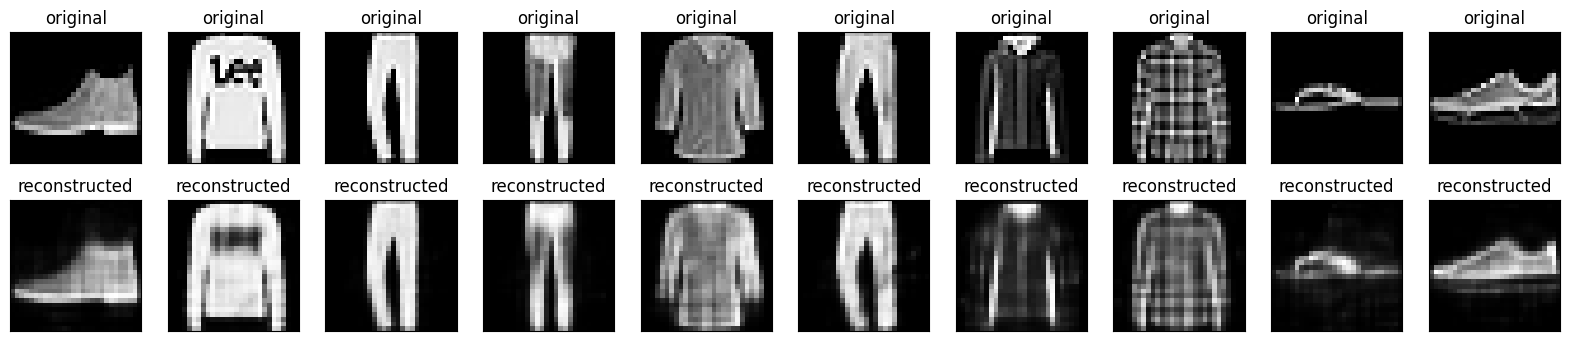

In [ ]:
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):  # n번 반복하며 원본 이미지와 복원된 이미지 비교하여 시각화
  ax = plt.subplot(2, n, i+1)  # 원본 이미지
  plt.imshow(x_test[i])
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, n, i+1+n)  # 복원된 이미지
  plt.imshow(decoded_imgs[i])
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# AE를 이용한 denosing
- noise를 제거하는 모델 생성
- 학습할때 데이터에 noise를 추가하여 학습
- 공통 부분을 학습하며, noise를 제거한다. (입력된 데이터가 noise인 것을 알 수 있게 하기위한 목적)

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/ 255  # 정규화
x_test = x_test.astype('float32') / 255
x_train = x_train[..., tf.newaxis]  # 차원 확장 (tf.newaxis : 마지막 차원에 차원을 추가)
x_test = x_test[..., tf.newaxis]    # 차원 확장하는 이유는 이미지 데이터를 채널 차원을 가지는 형태로 변환
print(x_train.shape)  # (60000, 28, 28, 1)  60000개 데이터수, 28x28, 1은 흑백 이미지

(60000, 28, 28, 1)


In [ ]:
noise_factor = 0.2  # 노이즈 크기를 제어하는 값
x_train_noisy = x_train + noise_factor * tf.random.normal(shape = x_train.shape)  # 노이즈 생성 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape = x_test.shape) # shape : 원본이미지와 같은 형태의 노이즈
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0., clip_value_max = 1,)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0., clip_value_max = 1,)
# clip_by_value() : 이미지 값을 0과 1 사이로 cliping한다. (이미지 픽셀값을 0 미만, 1 초과 값으로 제한하여 범위 유지)

In [ ]:
# PCA는 noise를 제거함 : noise로부터 학습했을 때, noise가 제거됨.

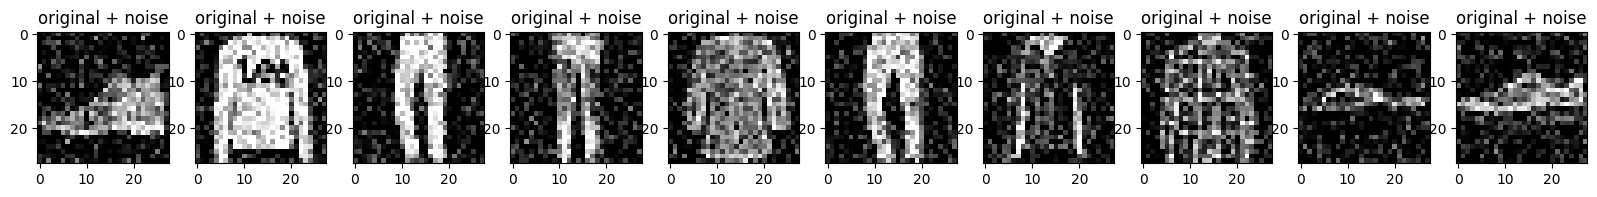

In [ ]:
n = 10
plt.figure(figsize = (20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))  # 불필요한 차원을 제거
  plt.gray()
plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([  # 입력이미지 차원축소를 위해 Conv2D 레이어로 인코딩한다. 
        layers.Input(shape = (28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),  # 14x14x16 / 16개, 3x3 크기 필터 
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)  # 7x7x8 / 8개
    ])
    # Conv2DTranspose = Conv2D + Upsampling을 결합
    self.decoder = tf.keras.Sequential([  # 인코딩된 이미지를 다시 원래차원으로 복원하기 위해 Conv2DTranspose 레이어 사용
        layers.Conv2DTranspose(8, kernel_size = 3, strides = 2, activation = 'relu',   # 14x14x8
                               padding = 'same'),
        layers.Conv2DTranspose(16, kernel_size = 3, strides = 2, activation = 'relu',  # 28x28x16 
                               padding = 'same'),
        layers.Conv2D(1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')  # 28x28x1
    ])
  def call(self, x):  # call() : 입력 이미지를 인코딩하고 디코딩하여 복원된 이미지 호출
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()  # 인스턴스
autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

In [ ]:
# strides를 사용하는 것 vs pooling을 사용하는 것
# 어떤 것이 유리한가?
# -> pooling이 유리하다 : strides는 계산이 안되는 부분이 있다.

# Conv2D + Upsampling을 사용하는 것 vs Conv2DTranspose를 사용하는 것
# 어떤 것이 유리한가?
# -> Conv2DTranspose : 계산을 촘촘하게 함.

In [ ]:
# Denoise 모델을 사용하여 노이즈 있는 이미지를 입력으로 받아
# 노이즈를 제거하고 원본 이미지와 비교하여 학습

autoencoder.fit(x_train_noisy, x_train, epochs = 10, shuffle = True,
                validation_data = (x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0176 - val_loss: 0.0105
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
encoded_imgs.shape  # 특징을 어떻게 추출해야 하는가? 
# (10000, 7, 7, 8)

(10000, 7, 7, 8)

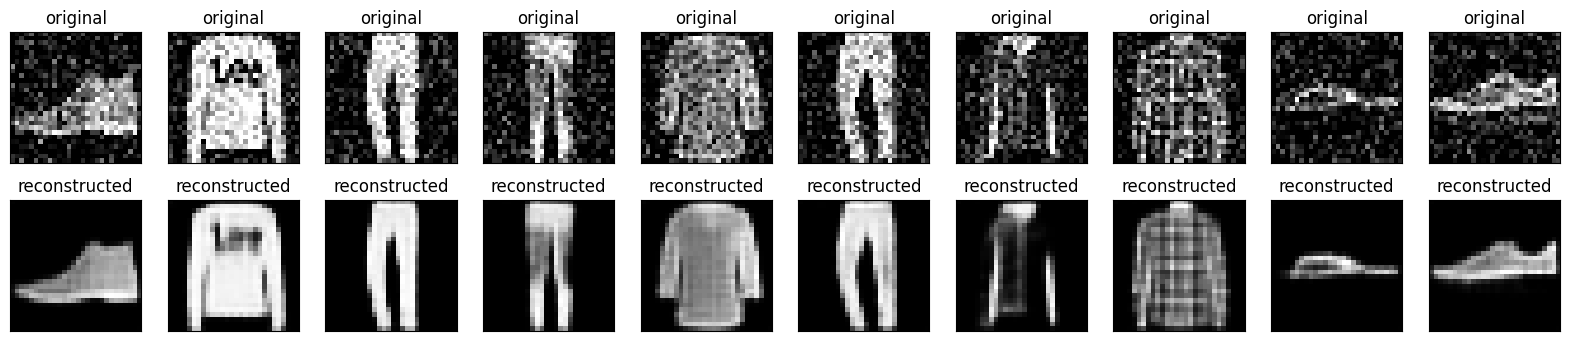

In [ ]:
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):  # n번 반복하며 원본 이미지와 복원된 이미지 비교하여 시각화
  ax = plt.subplot(2, n, i+1)  # 원본 이미지
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, n, i+1+n)  # 복원된 이미지
  plt.imshow(decoded_imgs[i])
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
# 노이즈가 제거됨

In [ ]:
# 문제
# 위의 encoder와 decoder의 가중치?
# 추출된 압축 특징 결과를 분류기에서 사용할 수 있도록 fully connected하기

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(encoded_imgs.shape)  # 특징을 추출
encoded_features = encoded_imgs.reshape(10000, -1)  # 분류기의 입력으로 사용 가능
# AE를 이용해서 PCA를 적용한 것과 같은 의미의 데이터를 생성하여 전달
encoded_features.shape

(10000, 7, 7, 8)


(10000, 392)

# LSTM을 이용해서 AE 모델을 학습
# Bearing 데이터를 이용하여 abnormal detection(이상 탐지)
  - threshold를 결정 (이상 여부 결정)
  - 비지도학습으로 결정
# AE 모델에서 정상 / 비정상
# 경계선을 결정
# 완벽한 모델은 이상이 없는 데이터를 100% 확률로 분류해야한다.
# 이상탐지로 전처리 후 모델 적용하는 것이 100% 완전 자동화를 위한 방법 - 수작업을 적용

# 지도학습인 경우에도 이상탐지를 이용해서 확인하는 것이 중요하다.
# 모델이 완성되면, 오분류 여부 확인 불가능 (라벨이 없는 데이터에 대하여 라벨링을 하는것이 지도학습)

In [ ]:
# 문제 
# 업로딩한 데이터(Sensor data)를 /content/data/bearing_data로 압축해제하기
# Zipfile

In [11]:
# 폴더를 생성하고 원하는 위치에 압축 해제
import os
from os import path
os.makedirs('/content/data/bearing_data', exist_ok=True)

In [12]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Sensor Data/Bearing_Sensor_Data_pt1.zip', 'r') as zip:
  zip.extractall('./data/bearing_data')  # zip파일 압축 해제
  print('done')

done


In [13]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Sensor Data/Bearing_Sensor_Data_pt2.zip', 'r') as zip:
  zip.extractall('./data/bearing_data')  # zip파일 압축 해제
  print('done')

done


In [ ]:
# 사용 데이터
# 진동 데이터 : bibrattion -> 자동화기기 (이송, 시각, 다듬기 -> 회전)
# 회전 -> bearing -> sound를 저장한다. (10분(seed)동안)
# 정상 / 비정상일 때 사운드가 다르다 (model이 다름을 구분하도록 학습함)
#  -> 고장 (앞으로 1달 후 고장날 소리)
# 유지보수

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [15]:
seed(10)
tf.random.set_seed(10)

In [16]:
# 저장한 데이터에 불필요한 내용을 제거 (데이터가 MAC에서 처리)
!rm -r /content/data/bearing_data/__MACOSX  # recursive

In [ ]:
# 비지도학습이기에, 라벨링이 안되어있는 데이터
data_dir = '/content/data/bearing_data'
merged_data = pd.DataFrame()
for filename in os.listdir(data_dir):
  dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
  dataset_mean_abs = np.array(dataset.abs().mean())  # 절대값 평균을 계산, numpy 배열 형태
  dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))  # 모든 데이터 취합(1x4)
  dataset_mean_abs.index = [filename]
  merged_data = merged_data.append(dataset_mean_abs)  # merged_data DF에 계산된 절대값 평균 추가
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']  # 열이름

In [18]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.18.14.42.39,0.116935,0.086315,0.088653,0.056617
2004.02.15.01.32.39,0.060475,0.073321,0.075527,0.043839
2004.02.17.23.12.39,0.080193,0.077519,0.079501,0.047725
2004.02.17.11.42.39,0.115173,0.078393,0.079339,0.051855
2004.02.17.20.22.39,0.079498,0.078797,0.080790,0.048007


In [19]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()  # chronological (시간순으로) 정렬
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print('Dataset shape:', merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [24]:
# Timeseries 데이터
train = merged_data['2004-02-12 10:52:39':'2004-02-15 12:52:39']  # 기간에 해당하는 데이터를 train 데이터셋으로 추출
test = merged_data['2004-02-15 12:52:39':]  # 지정한 기간 이후의 데이터를 test 데이터셋으로 추출
print('Training dataset shape:', train.shape)  # Training dataset shape: (982, 4)
print('Test dataset shape:', test.shape)  # Test dataset shape: (538, 4)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


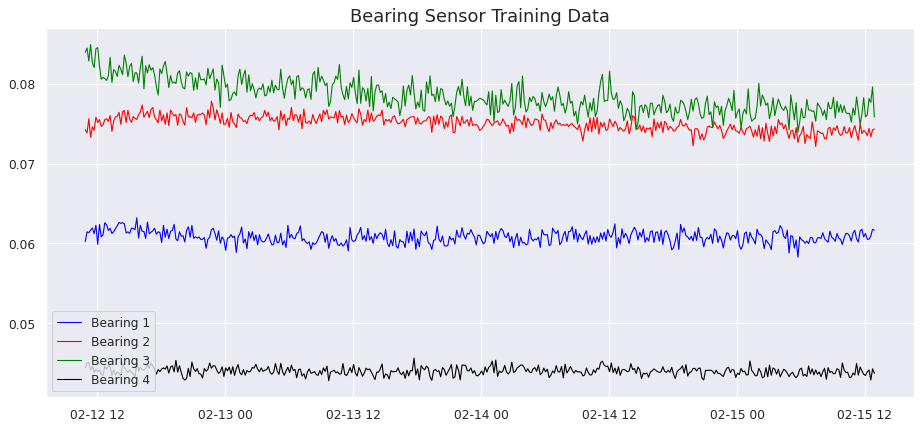

In [25]:
# 시각화
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(train['Bearing 1'], label = 'Bearing 1', color = 'blue', animated = True, linewidth = 1)
ax.plot(train['Bearing 2'], label = 'Bearing 2', color = 'red', animated = True, linewidth = 1)
ax.plot(train['Bearing 3'], label = 'Bearing 3', color = 'green', animated = True, linewidth = 1)
ax.plot(train['Bearing 4'], label = 'Bearing 4', color = 'black', animated = True, linewidth = 1)
plt.legend(loc = 'lower left')
ax.set_title('Bearing Sensor Training Data', fontsize = 16)
plt.show()

In [26]:
# 센서 데이터 정규화
scaler = MinMaxScaler()  # 최소-최대 스케일링
X_train = scaler.fit_transform(train)  # train 데이터셋 스케일링
X_test = scaler.transform(test)  # test 데이터셋 스케일링 (transform : 이미 학습된 스케일러 객체를 사용하여 데이터 스케일링)
scaler_filename = 'scaler_data'  # 파일명
joblib.dump(scaler, scaler_filename)  # 스케일러 객체를 직렬화하고 파일로 저장

['scaler_data']

In [28]:
# LSTM 데이터 입력 순서에 맞추어 reshape(samples, timesteps, features)
# 데이터 재구성(복원)
# LSTM 모델의 입력형태에 맞춰 각각의 데이터 샘플이 timesteps를 가지는 형태로 표현된다. (시계열 데이터 특성을 학습하기 위함)
# X_train.shape[0] : 데이터의 샘플 개수, 1 : 시간단계의 개수, X_train.shape[1] : 특징 개수
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # X_train 재구성 - LSTM에 맞는 형태로 변환
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [29]:
# AE : LSTM으로 구현 - 시계열 데이터의 특징 추출
                          # samples, timesteps, features
def autoencoder_model(X): # 인덱스 0, 1, 2
  inputs = Input(shape = (X.shape[1], X.shape[2]))
  L1 = LSTM(16, activation = 'relu', return_sequences = True,  # timesteps 개수만큼 출력
            kernel_regularizer = regularizers.l2(0.00))(inputs)
  L2 = LSTM(4, activation = 'relu', return_sequences = False)(L1)  # 특징 추출
  # 마지막 hidden state를 사용한다.
  L3 = RepeatVector(X.shape[1])(L2)  # timesteps만큼 반복하여 데이터를 생성
  L4 = LSTM(4, activation = 'relu', return_sequences = True)(L3)
  L5 = LSTM(16, activation = 'relu', return_sequences = True)(L4)
  # samples 수만큼 반복하여 들어온다.
  output = TimeDistributed(Dense(X.shape[2]))(L5)  # 입력데이터를 시간순으로 더한다.
  model = Model(inputs = inputs, outputs= output)
  return model

In [30]:
model = autoencoder_model(X_train)  # AE 모델 생성, 학습 데이터 기반으로 모델의 입력크기 결정됨
model.compile(optimizer = 'adam', loss='mae')  # 생성된 AE 모델 컴파일, mae 손실함수
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs = nb_epochs, batch_size = batch_size,
                    validation_split = 0.05).history

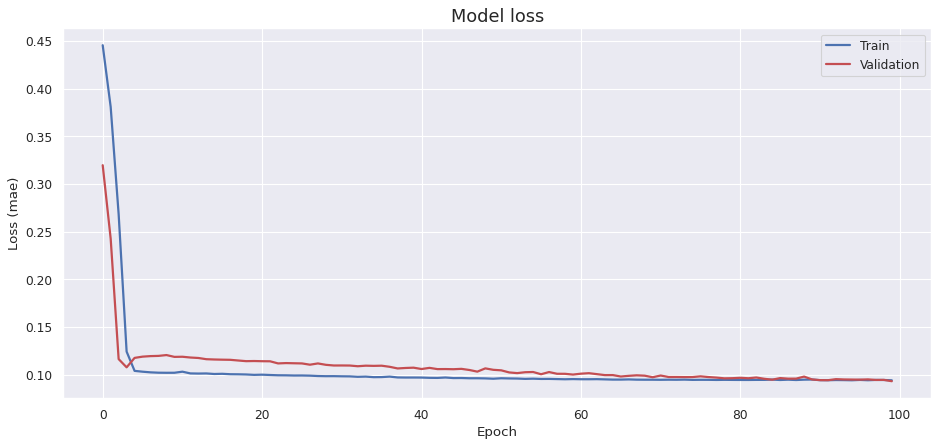

In [34]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['loss'], 'b', label='Train', linewidth = 2)  # 학습 손실값
ax.plot(history['val_loss'], 'r', label='Validation', linewidth = 2)  # 검증 손실값
ax.set_title('Model loss', fontsize = 16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc= 'upper right')
plt.show()

14/14 [==============================] - 1s 3ms/step


<ipython-input-35-fae9cf9e2dd5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde=True, color = 'blue')


(0.0, 0.5)

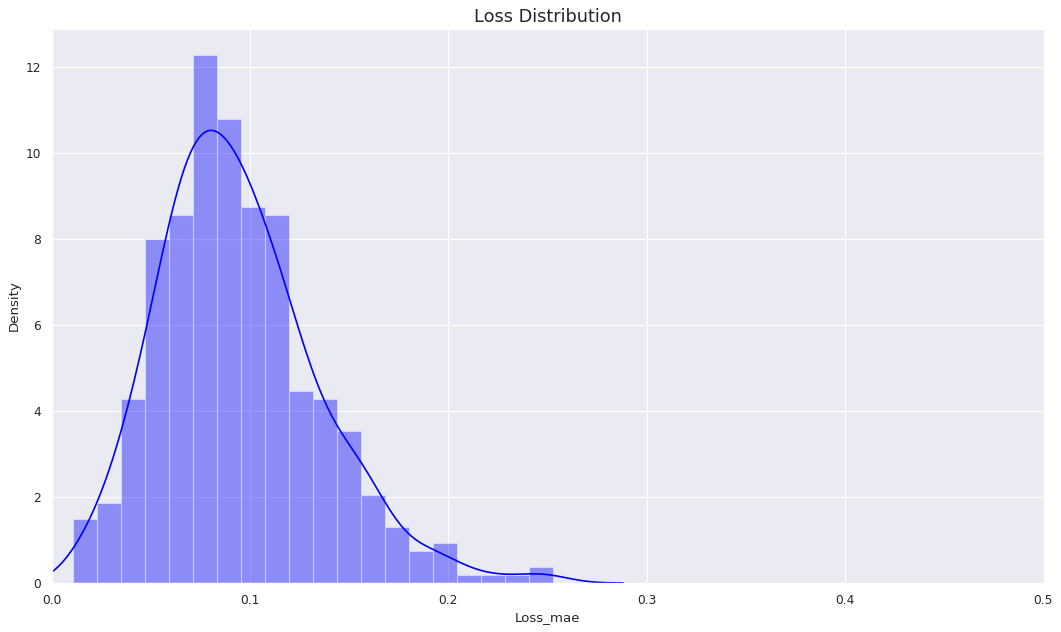

In [35]:
# LSTM (samples, timesteps, features) 입력
# timesteps 없애기 : 이유는, 1차원이 추가되었기에.
X_pred = model.predict(X_train)  # 학습 데이터에 대한 예측결과
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])  # 예측결과 차원 조정
X_pred = pd.DataFrame(X_pred, columns = train.columns)
X_pred.index = train.index  # 분포도를 그릴 때에 섞이기에 두 데이터를 일치시킨다.

scored = pd.DataFrame(index = train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])  # 실제 데이터를 변형
scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtrain), axis = 1)  # 절대값 차이를 평균값으로 대체 / 손실값 계산
plt.figure(figsize = (16, 9), dpi = 80)
plt.title('Loss Distribution', fontsize = 16)
# 분포도 그리기 
sns.distplot(scored['Loss_mae'], bins = 20, kde=True, color = 'blue')
plt.xlim([0.0, .5])  # x축 범위

In [37]:
# 테스트 데이터에 대한 예측 결과를 계산하고
# 손실(Loss) 값을 기준으로 이상(Anomaly)을 판별
X_pred = model.predict(X_test)  # 테스트 데이터 예측결과
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = test.columns)  # 예측결과를 데이터프레임으로 변환
X_pred.index = test.index  # 분포도를 그릴 때에 섞이기에 두 데이터를 일치시킨다.

scored = pd.DataFrame(index = test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis = 1)  # 손실값(Loss) 계산
scored['Threshold'] = 0.29  # 경계점 (손실 값의 임계값, 이 값을 기준으로 이상여부 판별)
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

17/17 [==============================] - 0s 4ms/step


,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.091075,0.29,False
2004-02-15 13:02:39,0.174722,0.29,False
2004-02-15 13:12:39,0.057250,0.29,False
2004-02-15 13:22:39,0.060048,0.29,False
2004-02-15 13:32:39,0.043648,0.29,False


In [38]:
X_pred_train = model.predict(X_train)  # 학습 데이터에 대한 예측 결과를 계산
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns = train.columns)  # 예측결과를 데이터프레임으로 변환
X_pred_train.index = train.index  # 예측 결과의 인덱스를 학습 데이터의 인덱스로 설정 (일치)

scored_train = pd.DataFrame(index = train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis = 1)  # 손실 값(Loss) 계산
scored_train['Threshold'] = 0.29  # 경계점
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])  # 학습 데이터와 테스트 데이터에 대한 이상 판별 결과 결합

14/14 [==============================] - 0s 3ms/step


<Axes: >

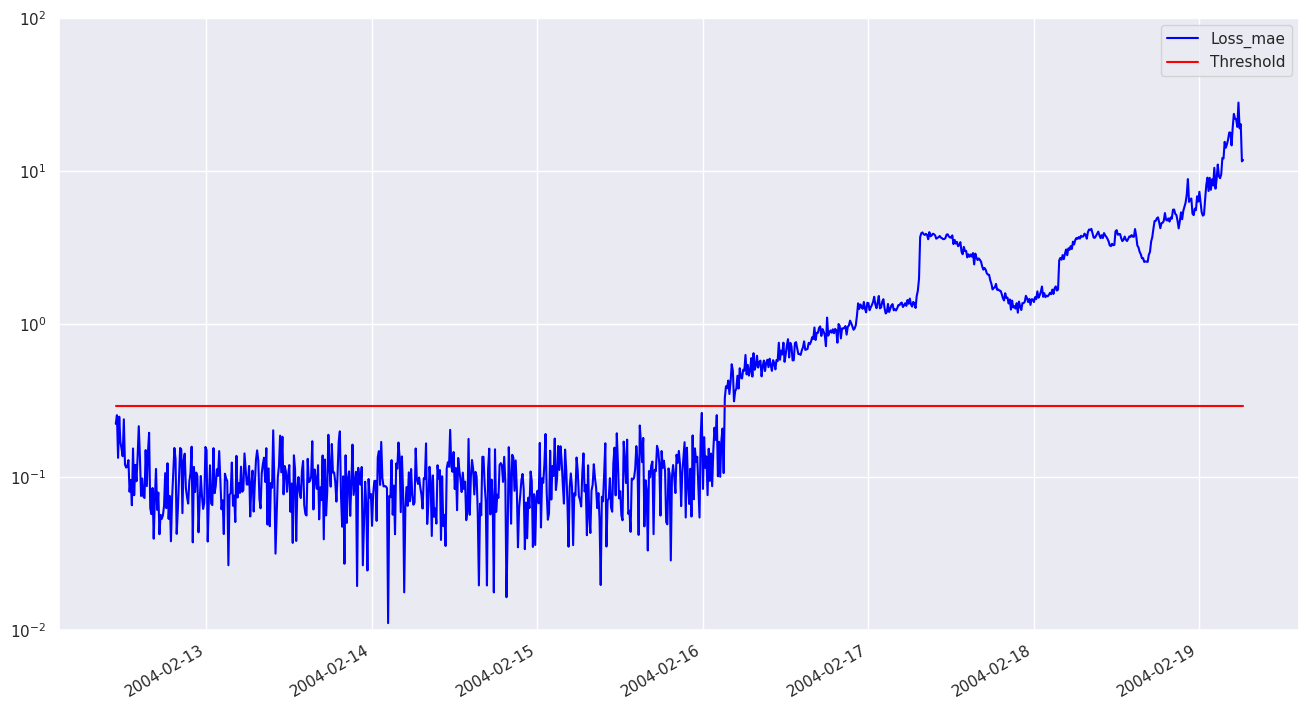

In [39]:
scored.plot(logy = True, figsize=(16, 9), ylim = [1e-2, 1e2], color = ['blue', 'red'])

In [40]:
model.save('Cloud_model.h5')
print('Model saved')

Model saved


# GAN

In [45]:
import os
if not os.path.exists('./gan_images'):
  os.makedirs('./gan_images')
np.random.seed(3)
tf.random.set_seed(3)

In [46]:
# 생성자 모델 

from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
import tensorflow as tf
import matplotlib.pyplot as plt

# fake 이미지 생성
generator = Sequential()
# 1차원으로 데이터를 입력 : random으로부터 학습된 가중치로 이미지를 생성
# 실제 서비스하는 망(network)
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))  # 입력되는 잡음벡터 크기 : 100*(128*7*7)
generator.add(BatchNormalization())  # -1 ~ 1 분포로 재조정 (통계학)
generator.add(Reshape((7, 7, 128)))  # 1차원 벡터를 7x7x128 크기의 텐서로 변환
generator.add(UpSampling2D())  # 14x14x128 / 크기 확대 (고해상도의 이미지 생성)
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))  # 14x14x64 / 5x5 크기 커널 사용하여 이미지 학습 (64채널)
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))  # -1까지만 고려 (ReLU는 음수를 고려하지 않는다)
generator.add(UpSampling2D())  # 28x28x64
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation='tanh'))  # 28x28x1 / -1 ~ 1 사이 값으로 정규화
# GAN 모델에서 실제 이미지와 유사한 가짜 이미지 -> 위 구조의 생성자

In [47]:
# 분별자 모델

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape=(28, 28, 1),  # 5x5 커널과 strides 2를 사용하여 입력이미지 학습
                         padding = 'same'))  # 14x14x64
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))  # 학습 도중에 일부 뉴런을 비활성화 (과적합 방지)
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))  # 7x7x128
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())  # 7x7x128
discriminator.add(Dense(1, activation = 'sigmoid'))  # 1개의 뉴런을 가지는 Dense layer / True / False로 판별 (이진분류)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False  # 가중치를 학습하지 않는다.

In [48]:
# gan 모델 (생성자 + 판별자 모델, 동시에 학습)

ginput = Input(shape = (100, ))  # 랜덤한 데이터가 입력됨
dis_output = discriminator(generator(ginput))  # 가짜 이미지를 판별기에 투입
gan = Model(ginput, dis_output)  # functional로 모델을 생성할 때 사용 (입력과 출력을 연결) (입력:잡음벡터, 출력:감별자의 출력)
gan.compile(loss='binary_crossentropy', optimizer='adam')  # GAN 모델은 가짜 이미지를 생성하고 감별자를 속이는 것이 목표
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [50]:
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_, _) = mnist.load_data()  # 기본 이미지 / 데이터셋 로드
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')  # GAN 모델에 맞는 형태로 변환하기 / reshape, 정규화(-1 ~ 1)
  X_train = (X_train - 127.5) / 127.5  # 이미지 정규화 (-1 ~ 1)
  # 비지도학습 : 원래 비지도학습은 라벨이 없음 / 가짜 라벨을 생성
  true = np.ones((batch_size, 1))  # 실제 이미지 (1로 라벨 생성, real)
  fake = np.zeros((batch_size, 1))  # 가짜 이미지 (0으로 라벨 생성, fake))
  for i in range(epoch):  # 지정된 epoch 횟수만큼 반복하면서 GAN 모델 훈련
    # 이미지 인덱스를 생성
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    # fit / train_on_batch
    # fit : 일관성 있는 학습 (항상 같은 사이즈일때)
    # train_on_batch : 가변적 학습 (배치 사이즈가 바뀔 때도 사용 가능하고, 같은 사이즈일때도 사용 가능) (이미 학습된 데이터에 추가학습 가능)
    d_loss_real = discriminator.train_on_batch(imgs, true)  # True인 경우
    noise = np.random.normal(0, 1, (batch_size, 100))  # 이미지를 noise로 만듦 (100개씩, 랜덤하게)
    gen_imgs = generator.predict(noise)  # 이미지를 생성
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # False(가짜)인 경우 분별기로 학습
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # 반씩 영향을 미치도록 함.
    g_loss = gan.train_on_batch(noise, true)
    print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)  # epoch 번호 / 분별자 손실값(d_loss), 생성자 손실값(g_loss)
    # 중간마다 이미지를 저장하여 gan이 학습됨을 확인하는 회로
    if i % saving_interval == 0:  # 200번마다 생성된 이미지를 저장하며 확인
      noise = np.random.normal(0, 1, (25, 100))  # 노이즈 이미지 size 
      gen_imgs = generator.predict(noise)  # Test image 생성 
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):  # 5장씩 이미지를 출력
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig('gan_images/gan_mnist_%d.png' % i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 16ms/step
epoch:1508 d_loss:0.5024 g_loss:2.4921
1/1 [==============================] - 0s 17ms/step
epoch:1509 d_loss:0.3212 g_loss:2.1700
1/1 [==============================] - 0s 17ms/step
epoch:1510 d_loss:0.5308 g_loss:2.4330
1/1 [==============================] - 0s 23ms/step
epoch:1511 d_loss:0.4827 g_loss:1.8019
1/1 [==============================] - 0s 17ms/step
epoch:1512 d_loss:0.3906 g_loss:1.9086
1/1 [==============================] - 0s 18ms/step
epoch:1513 d_loss:0.4650 g_loss:1.5912
1/1 [==============================] - 0s 16ms/step
epoch:1514 d_loss:0.3640 g_loss:1.8614
1/1 [==============================] - 0s 18ms/step
epoch:1515 d_loss:0.4516 g_loss:2.1031
1/1 [==============================] - 0s 17ms/step
epoch:1516 d_loss:0.4528 g_loss:1.7790
1/1 [==============================] - 0s 17ms/step
epoch:1517 d_loss:0.3922 g_loss:2.3590
1/1 [==============================] - 0s 17ms/step
ep

<ipython-input-50-4e44fa1e2cad>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


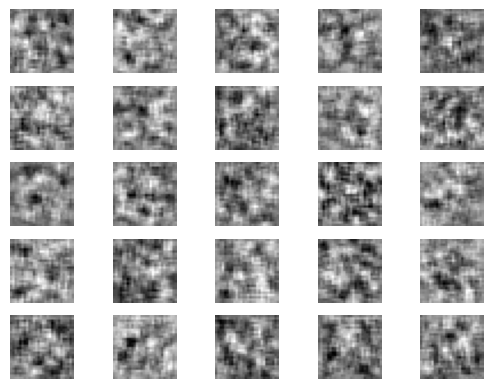

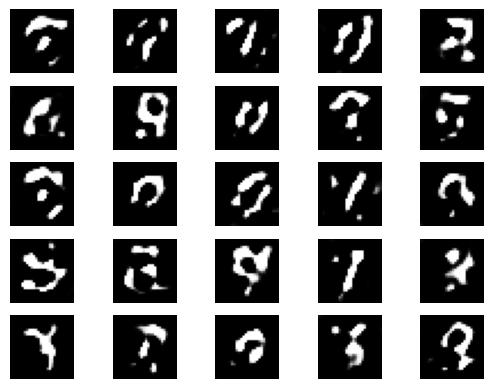

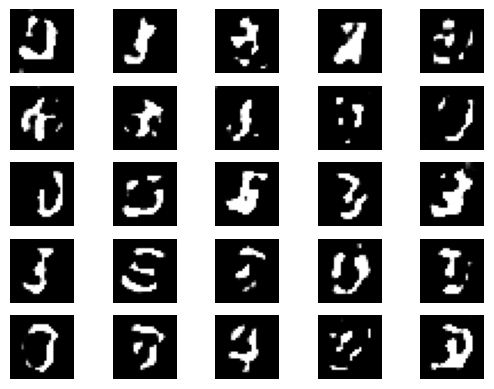

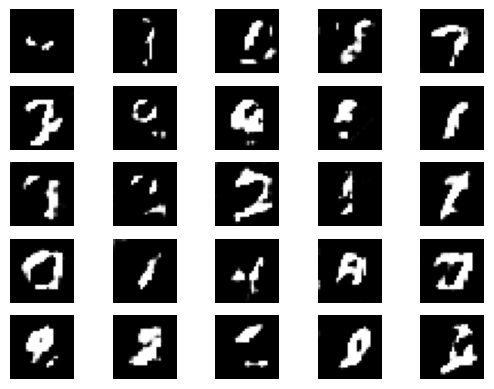

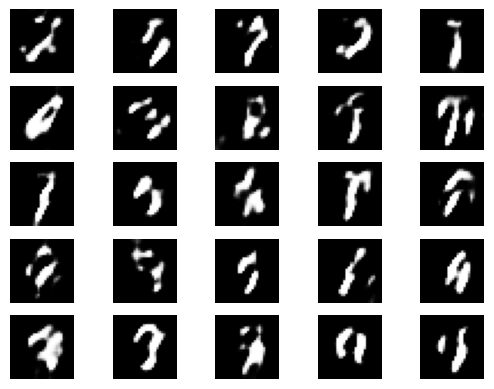

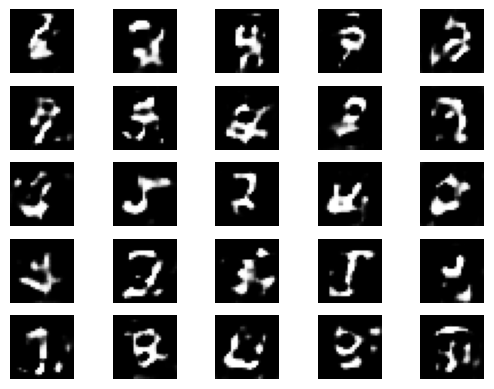

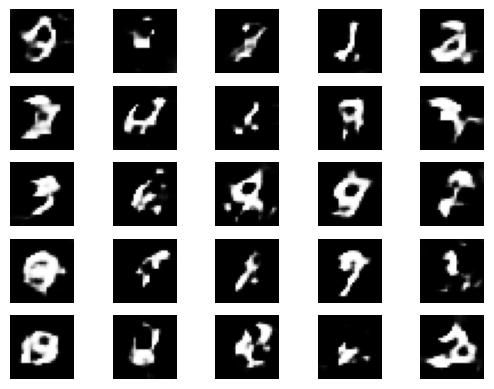

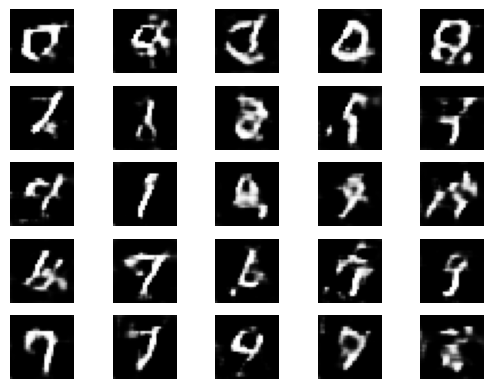

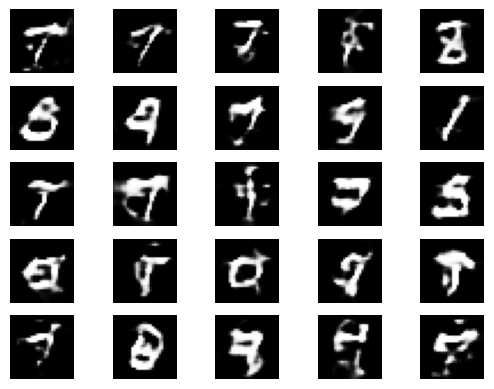

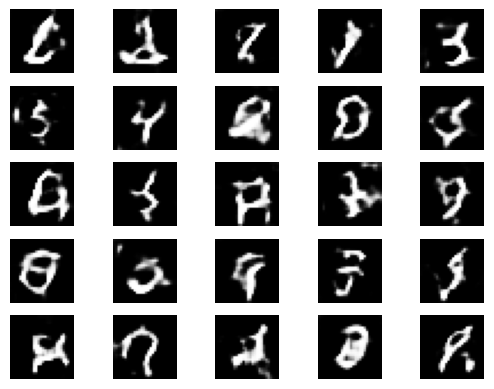

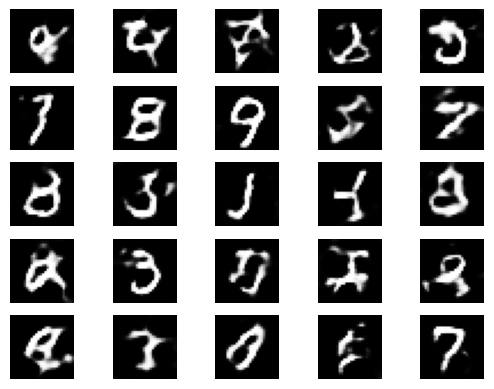

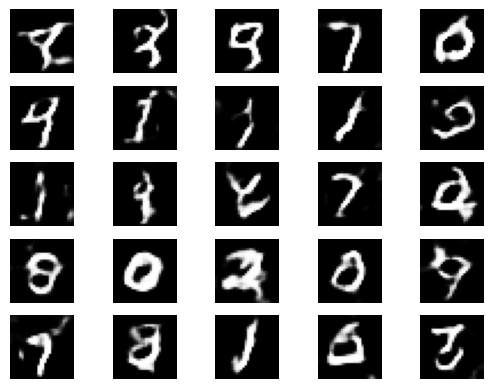

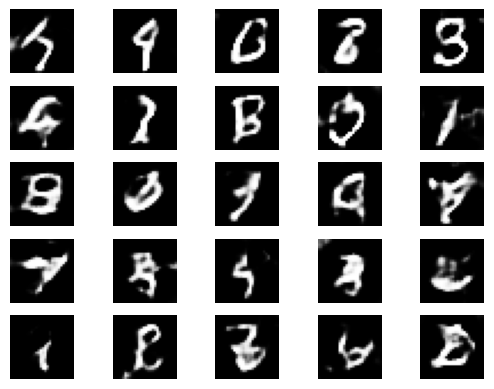

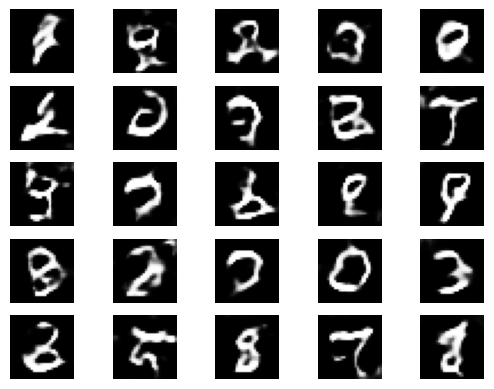

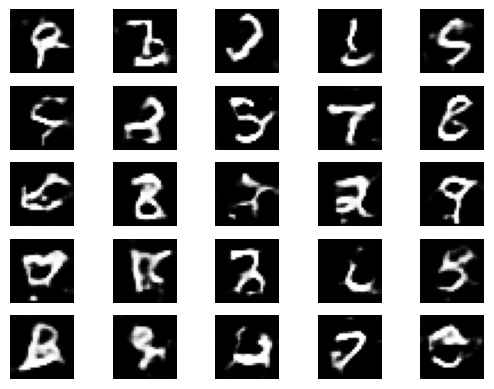

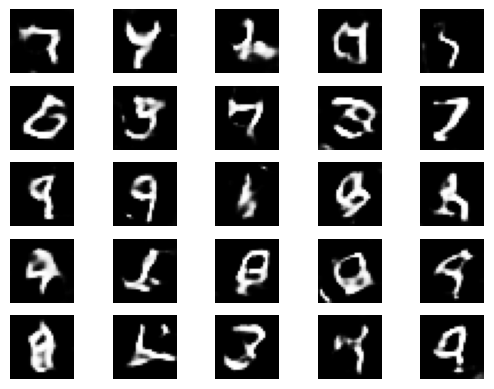

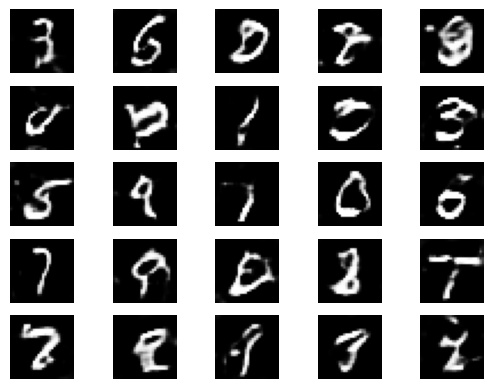

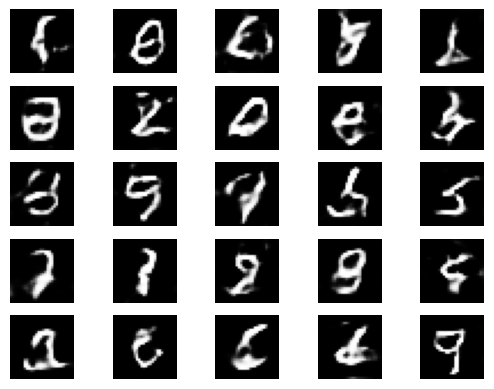

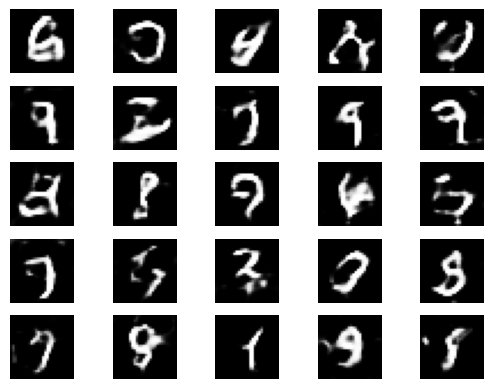

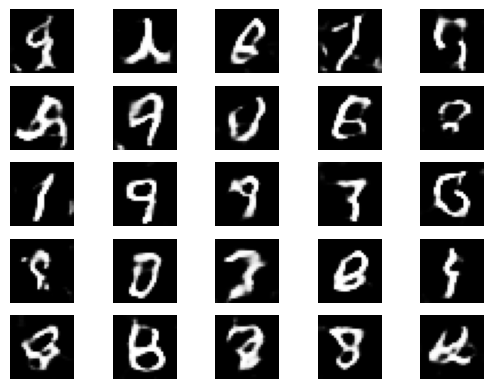

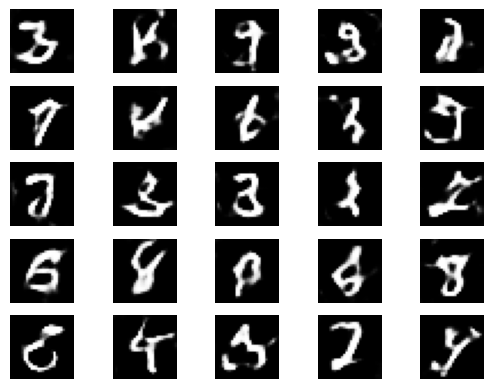

In [51]:
gan_train(4001, 32, 200)

In [ ]:
# 문제
# 이미지를 랜덤으로 생성하고, 이미지를 predict하여 출력 후 저장

In [ ]:
generator.save('/content/drive/MyDrive/generatormodel.h3')

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
model = keras.models.load_model('/content/drive/MyDrive/generatormodel.h3')
noise = np.random.normal(0, 1, (25, 100))
gen_imgs = model.predict(noise)  # 이미지 생성 (생성 공통분포 학습)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(5, 5)
count = 0
for j in range(5):
  for k in range(5):
    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
    axs[j, k].axis('off')
    count += 1